In [403]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import csv
import io
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [405]:
num_lags = 3
timesteps = 1
err_range = 0.5

In [406]:
# read in data
df = pd.read_csv('../j17_well.csv')
pd.DataFrame.reset_index(df, drop=True)
del df['Site']
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores["DailyHighDate"] = df['DailyHighDate']
z_scores['WaterLevelElevation'] = df['WaterLevelElevation']
z_scores['Z Scores'], mean, std = z_score_calc(df,'WaterLevelElevation') # noramlization speeds up learning and leads to faster convergence
z_scores.to_csv("j17wl_daily_z_scores.csv") 
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
cols = []
for i in range(num_lags):
    cols.append(i+1)
# prepare data
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
# ~80% training
ds_train_x = ds_x[:int(0.8*len(ds_x))]
ds_train_y = ds_y[:int(0.8*len(ds_x))]
# ~20% validating
ds_val_x = ds_x[int(0.8*len(ds_x)):]
ds_val_y = ds_y[int(0.8*len(ds_x)):]

In [412]:
# build NN
epochs = 100
batch_size = 100
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='sigmoid', input_dim=num_lags))
#model.add(keras.layers.Dense(10))
#model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(1)) # output layer; gives a 1D output
model.compile(optimizer='adam', loss='mse')
history = model.fit(ds_train_x, ds_train_y, batch_size=batch_size, epochs=epochs, verbose=2)
# apply to predictions
predictions = model.predict(ds_val_x)
r = []
for i in predictions:
    r.append(i[0])
result = np.array(r)
predicted_vals = result * std + mean
true_vals = ds_val_y * std + mean
diff = true_vals - predicted_vals
count_err = 0
count_1 = 0
for i in diff:
    if abs(i) <= err_range:
      count_err += 1
    if abs(i) <= 1.0:
      count_1 += 1
print("Predictions ±" + str(err_range) + " = " + str(count_err / len(diff) * 100) + "%")
print("Predictions ±1.0 = " + str(count_1 / len(diff) * 100) + "%")
corr_m = np.corrcoef(predicted_vals, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")

TypeError: fit() got an unexpected keyword argument 'batchsize'

In [395]:
plt.rcParams['font.family'] = 'serif'
f='Times'

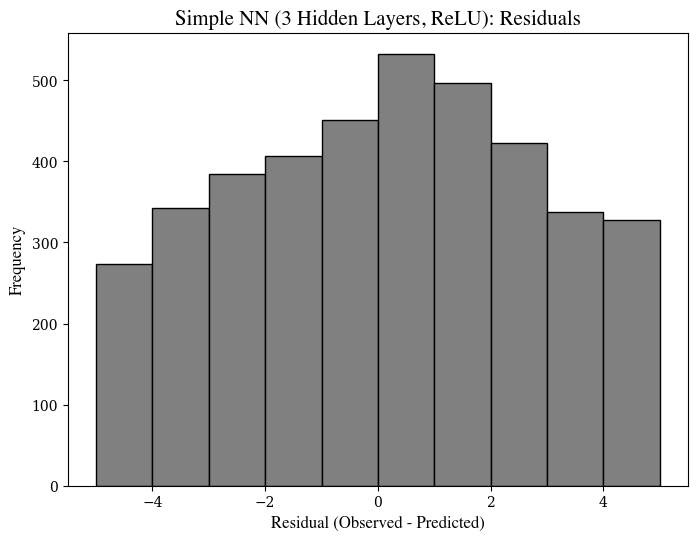

In [396]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

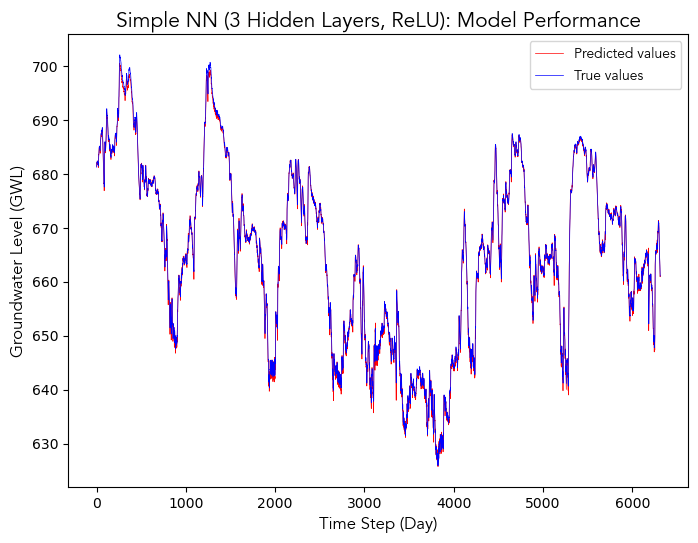

In [409]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})

In [398]:
model.save("simple_nn_D")

INFO:tensorflow:Assets written to: simple_nn_D/assets


In [399]:
plt.rcParams['font.family'] = 'sans-serif'
f='Avenir'

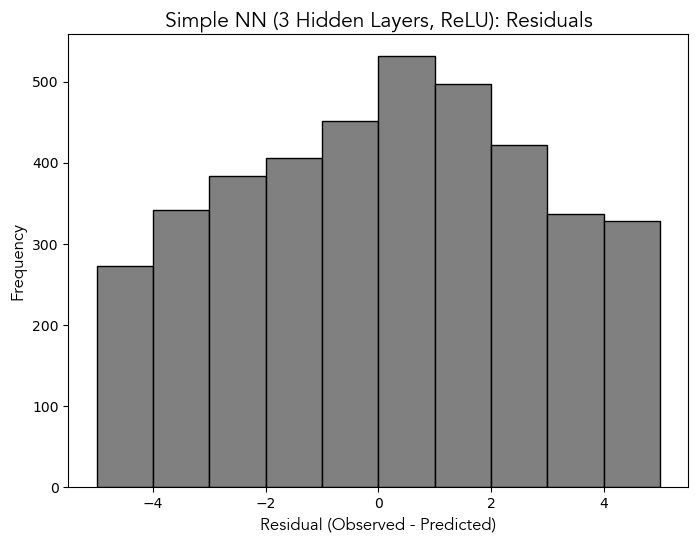

In [400]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

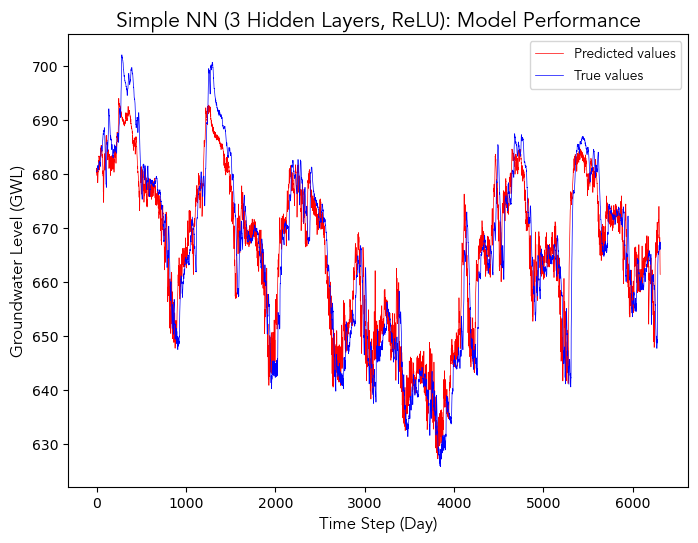

In [401]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})